### CÓDIGO PARA REALIZAR CONSULTAS , ANÁLISIS DE DATOS Y GENERACIÓN DE GRÁFICAS

In [1]:
import firebase_admin
from firebase_admin import credentials, firestore
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import tabulate
from tabulate import tabulate
import os



ModuleNotFoundError: No module named 'tabulate'

In [ ]:


#Se llaman las credenciales obtenidas en firebase, estas credenciales se pueden encontrar en Firebase y se descarga el archivo json, el cual es dado por Firebase
# Ruta al archivo de credenciales dentro de config/
config_path = os.path.join("config", "firebase-config.json")
cred = credentials.Certificate(config_path)

try:
    firebase_admin.get_app("default")
except ValueError:
    firebase_admin.initialize_app(cred, name="default")

app = firebase_admin.get_app("default")
db = firestore.client(app)

#En esta función se extraen los usuarios que se encuentran en la colección User de Firebase
def get_all_user_ids():
    users_ref = db.collection("User")
    user_docs = users_ref.stream()
    # Lista de usuarios que deseas excluir del análisis
    usuarios_a_excluir = ["example1@app.com", "example2@app.com"]

    # Filtrar los IDs de los usuarios que no están en la lista de exclusiones
    user_ids = [doc.id for doc in user_docs if doc.id not in usuarios_a_excluir]

    return user_ids
# Esta función se usa para obtener todos los IDs de usuarios
all_user_ids = get_all_user_ids()

print("Total de usuarios:", len(all_user_ids))
print("Todos los IDs de usuarios:")
print(all_user_ids)



#Se relacionan las colecciones con cada uno de los usuarios(Ver estructura de Firebase)
def get_user_data(user_id):

    user_doc_ref = db.collection("User").document(user_id)
    user_doc = user_doc_ref.get()
    if user_doc.exists:
      #Se asocia cada colección con el usuario
        user_data = get_doc_id_and_data(user_doc)
        user_data["Intentosf"] = get_user_intentos(user_id)
        user_data["Intentos"] = get_user_intentos0(user_id)
        user_data["Ejercicios"] = get_user_ejercicios(user_id)
        user_data["Tiempo"] = get_user_tiempo(user_id)
        return user_data
    else:
        return None

def get_user_intentos0(user_id):
    intentos_query0 = db.collection("Intentos").where("usuario", "==", db.collection("User").document(user_id))
    intentos_docs0 = intentos_query0.stream()
    intentos_data0 = [get_doc_id_and_data(doc) for doc in intentos_docs0]
    return intentos_data0

def get_user_intentos(user_id):
    intentos_query = db.collection("Intentosf").where("usuario", "==", db.collection("User").document(user_id))
    intentos_docs = intentos_query.stream()
    intentos_data = [get_doc_id_and_data(doc) for doc in intentos_docs]
    return intentos_data

def get_user_ejercicios(user_id):
    ejercicios_query = db.collection("Ejercicios").where("usuario", "==", db.collection("User").document(user_id))
    ejercicios_docs = ejercicios_query.stream()
    ejercicios_data = [get_doc_id_and_data(doc) for doc in ejercicios_docs]
    return ejercicios_data

def get_user_tiempo(user_id):
    tiempo_query = db.collection("Tiempo").where("usuario", "==", db.collection("User").document(user_id))
    tiempo_docs = tiempo_query.stream()
    tiempo_data = [get_doc_id_and_data(doc) for doc in tiempo_docs]
    return tiempo_data

def get_doc_id_and_data(doc):
    data = doc.to_dict()
    doc_id = doc.id

    # Convertir referencias a IDs
    for key, value in data.items():
        if isinstance(value, firestore.DocumentReference):
            data[key] = value.id
        elif isinstance(value, datetime):
            # Formatear la fecha como una cadena
            data[key] = value.strftime("%Y-%m-%d %H:%M:%S")

    return {"doc_id": doc_id, "data": data}




NameError: name 'os' is not defined

## Edad vs Puntos ganados

In [4]:
def create_user_points_table():
    # Crear una lista para almacenar los datos
    user_points_data = []

    # Iterar sobre todos los IDs de usuarios
    for user_id in all_user_ids:
        user_data = get_user_data(user_id)

        # Verificar si hay datos de tiempo para el usuario
        if "Tiempo" in user_data:
            for tiempo_entry in user_data["Tiempo"]:
                edad = user_data["data"].get("Edad") or user_data["data"].get("edad")
                # Comprobar si la entrada de tiempo tiene puntos_ganados y edad
                if "puntos_ganados" in tiempo_entry["data"] and edad is not None:
                    # Crear una entrada para la tabla
                    table_entry = {
                        "Usuario": user_id,
                        "Edad": edad,
                        "Puntos Ganados": tiempo_entry["data"]["puntos_ganados"]
                    }
                    # Agregar la entrada a la lista
                    user_points_data.append(table_entry)

    # Crear un DataFrame desde la lista de datos
    user_points_df = pd.DataFrame(user_points_data)


    # Imprimir el DataFrame
    print(user_points_df)
    # Convertir 'Edad' y 'Puntos Ganados' a tipo numérico
    user_points_df['Edad'] = pd.to_numeric(user_points_df['Edad'], errors='coerce')
    user_points_df['Puntos Ganados'] = pd.to_numeric(user_points_df['Puntos Ganados'], errors='coerce')

    #Generar un archivo csv con la tabla generada
    user_points_df.to_csv('user_points_data.csv', index=False)
    # Llamar a la función para crear la tabla

    return user_points_df


create_user_points_table()


NameError: name 'all_user_ids' is not defined

In [5]:
def create_scatter_plot(user_points_df):
    # Llamar a la función para crear la tabla
    #create_user_points_table()
    print("Tipos de datos en 'Edad':", user_points_df['Edad'].dtype)
    print("Tipos de datos en 'Puntos Ganados':", user_points_df['Puntos Ganados'].dtype)

    # Crear un gráfico de dispersión
    plt.figure(figsize=(10, 6))
    plt.scatter(user_points_df['Edad'], user_points_df['Puntos Ganados'], color='blue', alpha=0.5)
    plt.title('Relación entre Edad y Puntos Ganados')
    plt.xlabel('Edad')
    plt.ylabel('Puntos Ganados')
    plt.grid(True)
    plt.show()

    # Box plots por Edad
    sns.boxplot(x='Edad', y='Puntos Ganados', data=user_points_df)
    plt.title('Box Plot de Puntos Ganados por Edad')
    plt.show()


# Llamar a la función para crear la tabla
create_user_points_table()
user_points_df = create_user_points_table()
# Llamar a la función para crear el gráfico
create_scatter_plot(user_points_df)


NameError: name 'all_user_ids' is not defined

##Tiempo de uso vs Puntos totales


In [6]:
def create_app_usage_vs_points_plot(all_user_ids):
    # Lista para almacenar los datos
    app_usage_data = []

    # Iterar sobre todos los IDs de usuarios
    for user_id in all_user_ids:
        user_data = get_user_data(user_id)

        # Verificar si hay datos de tiempo para el usuario
        if "Tiempo" in user_data:
            for tiempo_entry in user_data["Tiempo"]:
                # Comprobar si la entrada de tiempo tiene puntos_ganados y uso_app
                if "puntos_ganados" in tiempo_entry["data"] and "total_acumulado" in tiempo_entry["data"]:
                    # Convertir el formato del tiempo a segundos (puedes ajustar según tus necesidades)
                    tiempo_en_segundos = pd.to_timedelta(tiempo_entry["data"]["total_acumulado"]).total_seconds()

                    # Crear una entrada para la lista
                    entry = {
                        "Usuario": user_id,
                        "Uso de la App (segundos)": tiempo_en_segundos,
                        "Puntos Ganados": tiempo_entry["data"]["puntos_ganados"]
                    }
                    # Agregar la entrada a la lista
                    app_usage_data.append(entry)

    # Crear un DataFrame desde la lista de datos
    app_usage_df = pd.DataFrame(app_usage_data)
    app_usage_df.to_csv('app_usage.csv', index=False)
    table = tabulate(app_usage_df, headers='keys', tablefmt='fancy_grid')
    print(table)

    # Imprimir el DataFrame
    #print(app_usage_df)

    # Crear un gráfico de dispersión
    plt.figure(figsize=(10, 6))
    plt.scatter(app_usage_df['Uso de la App (segundos)'], app_usage_df['Puntos Ganados'], color='blue', alpha=0.5)
    plt.title('Relación entre Uso de la App y Puntos Ganados')
    plt.xlabel('Uso de la App (segundos)')
    plt.ylabel('Puntos Ganados')
    plt.grid(True)
    plt.show()

# Ejemplo de uso:
all_user_ids = get_all_user_ids()
create_app_usage_vs_points_plot(all_user_ids)

NameError: name 'get_all_user_ids' is not defined

## Dispositivo vs Puntos totales

/usr/local/lib/python3.10/dist-packages/google/cloud/firestore_v1/base_collection.py:290: UserWarning: Detected filter using positional arguments. Prefer using the 'filter' keyword argument instead.
  return query.where(field_path, op_string, value)


   Dispositivo  Puntos Totales
0      ninguno               9
1      ninguno             154
2     implante             224
3     implante             194
4      ninguno              55
..         ...             ...
63     ninguno              17
64    implante              40
65    implante              94
66    implante              14
67    implante              27

[68 rows x 2 columns]


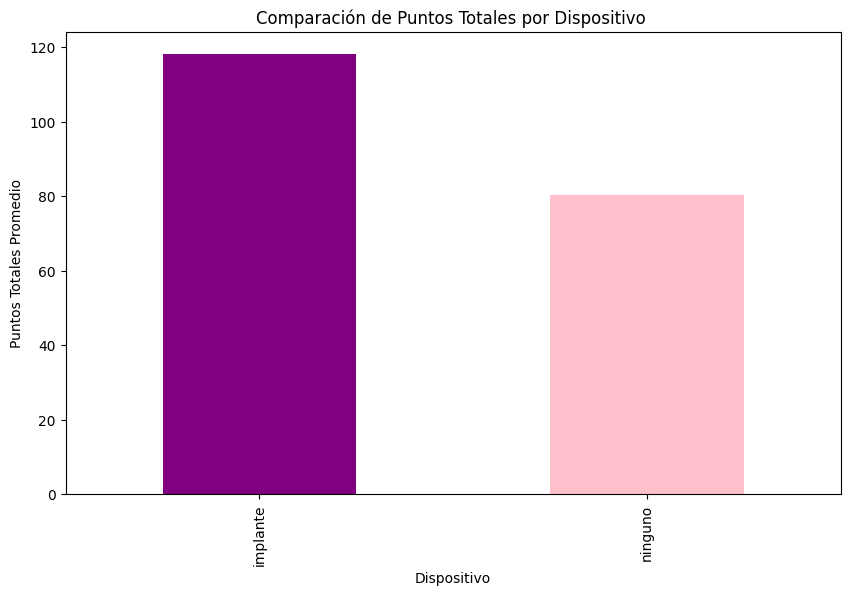

In [ ]:
def create_device_vs_points_bar_chart(all_user_ids, excluded_device="Auriculares"):
    # Lista para almacenar los datos
    device_points_data = []

    # Iterar sobre todos los IDs de usuarios
    for user_id in all_user_ids:
        user_data = get_user_data(user_id)

        # Verificar si hay datos de tiempo para el usuario
        if "Tiempo" in user_data:
            for tiempo_entry in user_data["Tiempo"]:
                # Comprobar si la entrada de tiempo tiene puntos_totales y dispositivo
                if "puntos_ganados" in tiempo_entry["data"]:
                    dispositivo = user_data["data"].get("tipo de dispositivo") or user_data["data"].get("Tipo de dispositivo")
                    if dispositivo:
                        # Convertir a minúsculas para manejar variabilidad en mayúsculas/minúsculas
                        dispositivo = dispositivo.lower()
                        # Excluir el dispositivo especificado
                        if dispositivo != excluded_device.lower():
                            # Crear una entrada para la lista
                            entry = {
                                "Dispositivo": dispositivo,
                                "Puntos Totales": tiempo_entry["data"]["puntos_ganados"]
                            }
                            # Agregar la entrada a la lista
                            device_points_data.append(entry)

    # Crear un DataFrame desde la lista de datos
    device_points_df = pd.DataFrame(device_points_data)

    # Imprimir el DataFrame
    print(device_points_df)

    # Crear un gráfico de barras agrupado
    plt.figure(figsize=(10, 6))
    device_groups = device_points_df.groupby("Dispositivo")
    device_groups["Puntos Totales"].mean().plot(kind='bar', color=['purple', 'pink'])
    plt.title('Comparación de Puntos Totales por Dispositivo ')
    plt.xlabel('Dispositivo')
    plt.ylabel('Puntos Totales Promedio')
    plt.show()


# Ejemplo de uso:
all_user_ids = get_all_user_ids()
create_device_vs_points_bar_chart(all_user_ids, excluded_device="Auriculares")

##Filtrar por ejercicio


###Filtrar por usuario


In [ ]:
def get_intentos_por_ejercicio(user_id):
    # Obtener todos los intentos del usuario (de ambas colecciones)
    intentos = get_user_intentos(user_id) + get_user_intentos0(user_id)

    # Organizar los intentos por ejercicio
    intentos_por_ejercicio = {}

    for intento in intentos:
        # Obtener el número de ejercicio
        numero_ejercicio = intento["data"].get("ejercicio")

        # Verificar si el intento tiene un número de ejercicio
        if numero_ejercicio is not None:
            # Añadir el intento al diccionario correspondiente al número de ejercicio
            if numero_ejercicio not in intentos_por_ejercicio:
                intentos_por_ejercicio[numero_ejercicio] = []
            intentos_por_ejercicio[numero_ejercicio].append(intento)

    return intentos_por_ejercicio

# Ejemplo de uso:
user_id_ejemplo = "alisonreyes@app.com"  # Reemplazar con un ID de usuario real
intentos_por_ejercicio = get_intentos_por_ejercicio(user_id_ejemplo)

# Imprimir toda la información sobre cada intento
for numero_ejercicio, intentos in intentos_por_ejercicio.items():
    print(f"\n\033[1m\033[96mIntentos para el Ejercicio {numero_ejercicio}:\033[0m")
    for intento in intentos:
        print(f"\nIntento ID: {intento['doc_id']}")
        for key, value in intento['data'].items():
            print(f"{key}: {value}")



Intentos para el Ejercicio Ejercicio_1:

Intento ID: Intento_1117
Result Level 1: ['Acierto', 'Acierto', 'Falla', 'Acierto']
Time Level 1: [2096, 1052, 544, 2414]
usuario: alisonreyes@app.com
fecha: 2024-02-16 15:09:17
puntos: 3
ejercicio: Ejercicio_1

Intento ID: Intento_1118
Result Level 1: ['Acierto', 'Falla', 'Falla', 'Acierto']
ejercicio: Ejercicio_1
puntos: 2
usuario: alisonreyes@app.com
fecha: 2024-02-16 15:10:25
Time Level 1: [1147, 6, 2982, 951]

Intento ID: Intento_1119
usuario: alisonreyes@app.com
Time Level 1: [1160, 2640, 3719, 1487]
ejercicio: Ejercicio_1
Result Level 1: ['Acierto', 'Acierto', 'Acierto', 'Acierto']
puntos: 4
fecha: 2024-02-16 15:10:49

Intento ID: Intento_1120
puntos: 2
usuario: alisonreyes@app.com
fecha: 2024-02-16 15:11:07
ejercicio: Ejercicio_1
Result Level 1: ['Falla', 'Falla', 'Acierto', 'Acierto']
Time Level 1: [4186, 9, 1, 10]

Intento ID: Intento_1121
Result Level 1: ['Acierto', 'Acierto', 'Acierto', 'Acierto']
Time Level 1: [5876, 2602, 2087, 98

/usr/local/lib/python3.10/dist-packages/google/cloud/firestore_v1/base_collection.py:290: UserWarning: Detected filter using positional arguments. Prefer using the 'filter' keyword argument instead.
  return query.where(field_path, op_string, value)


#### Consultar por variables y generar una tabla con las variables que se consultan de cada intento

In [ ]:

import tabulate

def get_intentos_por_ejercicio(user_id):
    # Obtener todos los intentos del usuario (de ambas colecciones)
    intentos = get_user_intentos(user_id) + get_user_intentos0(user_id)

    # Organizar los intentos por ejercicio
    intentos_por_ejercicio = {}

    for intento in intentos:
        # Obtener el número de ejercicio
        numero_ejercicio = intento["data"].get("ejercicio")

        # Verificar si el intento tiene un número de ejercicio
        if numero_ejercicio is not None:
            # Añadir el intento al diccionario correspondiente al número de ejercicio
            if numero_ejercicio not in intentos_por_ejercicio:
                intentos_por_ejercicio[numero_ejercicio] = []
            intentos_por_ejercicio[numero_ejercicio].append(intento)

    return intentos_por_ejercicio

# Ejemplo de uso:
user_id_ejemplo = "alisonreyes@app.com"  # Reemplazar con un ID de usuario real
intentos_por_ejercicio = get_intentos_por_ejercicio(user_id_ejemplo)

# Generar una tabla con puntos y tiempo
tabla_intentos = []
for numero_ejercicio, intentos in intentos_por_ejercicio.items():
    for intento in intentos:

        # Obtener la variable de interés (puntos o aciertos) o dejarla en blanco si ninguna está presente
        puntos_aciertos = intento['data'].get('puntos', intento['data'].get('aciertos', 0))

        # Filtrar las variables de interés (tiempo)
        tiempo = intento['data'].get('Time Level 1')or intento['data'].get('Time Level 2')or intento['data'].get('Time Level 3')or intento['data'].get('Time Level 4')or intento['data'].get('tiempo de Respuesta:')or intento['data'].get('tiemposOkList')

        # Agregar los datos a la tabla
        tabla_intentos.append({
            'Ejercicio': numero_ejercicio,
            'Puntos o Aciertos': puntos_aciertos,
            'Tiempo': tiempo
        })

# Imprimir la tabla utilizando tabulate
print(tabulate.tabulate(tabla_intentos, headers='keys', tablefmt='fancy_grid'))


╒══════════════╤═════════════════════╤═════════════════════════════════════════════════════════════════════════════════════╕
│ Ejercicio    │   Puntos o Aciertos │ Tiempo                                                                              │
╞══════════════╪═════════════════════╪═════════════════════════════════════════════════════════════════════════════════════╡
│ Ejercicio_1  │                   3 │ [2096, 1052, 544, 2414]                                                             │
├──────────────┼─────────────────────┼─────────────────────────────────────────────────────────────────────────────────────┤
│ Ejercicio_1  │                   2 │ [1147, 6, 2982, 951]                                                                │
├──────────────┼─────────────────────┼─────────────────────────────────────────────────────────────────────────────────────┤
│ Ejercicio_1  │                   4 │ [1160, 2640, 3719, 1487]                                                            │


###Filtrar por ejercicio General

/usr/local/lib/python3.10/dist-packages/google/cloud/firestore_v1/base_collection.py:290: UserWarning: Detected filter using positional arguments. Prefer using the 'filter' keyword argument instead.
  return query.where(field_path, op_string, value)


Archivo CSV 'Ejercicio_General.csv' creado con éxito.
Usuario                       Edad  Tiempo de Respuesta (Lista)                                                   Promedio de Tiempo de Respuesta
--------------------------  ------  ----------------------------------------------------------------------------  ---------------------------------
alejandramendez@app.com         26  N/A                                                                           N/A
alfredogiraldo@app.com          57  N/A                                                                           N/A
alisonreyes@app.com             14  2851, 4940, 901, 5639                                                         3582.75
alisonreyes@app.com             14  2851, 4940, 901, 5639                                                         3582.75
alisonreyes@app.com             14  5285, 4802, 739, 3219, 2022                                                   3213.4
alisonreyes@app.com             14  5285, 4802, 739

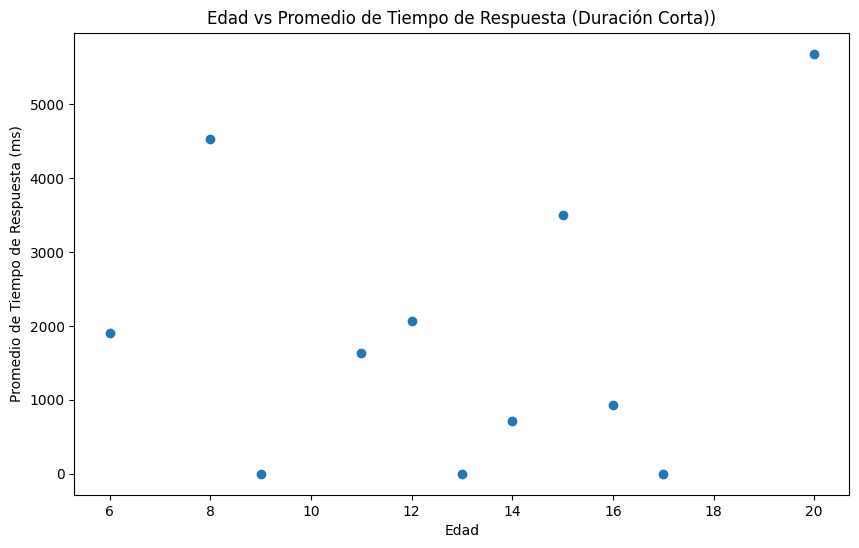

In [ ]:
import numpy as np
import tabulate
import matplotlib.pyplot as plt

def get_global_intentos_por_ejercicio(all_user_ids):
    intentos_por_ejercicio_global = {}

    for user_id in all_user_ids:
        intentos_por_ejercicio_usuario = get_intentos_por_ejercicio(user_id)

        # Combinar los resultados para todos los usuarios
        for numero_ejercicio, intentos in intentos_por_ejercicio_usuario.items():
            if numero_ejercicio not in intentos_por_ejercicio_global:
                intentos_por_ejercicio_global[numero_ejercicio] = []
            intentos_por_ejercicio_global[numero_ejercicio].extend(intentos)

    return intentos_por_ejercicio_global

all_user_ids = get_all_user_ids()
intentos_por_ejercicio_global = get_global_intentos_por_ejercicio(all_user_ids)

def generate_table_age_time(intentos_por_ejercicio, user_data,csv_filename='Ejercicio_General.csv'):
    if not intentos_por_ejercicio:
        print(f"No hay intentos para el ejercicio.")
        return
    table_data = []

    edades_promedios = {}  # Diccionario para almacenar los promedios por edad

    for intento in intentos_por_ejercicio:
        user_id = intento['data']['usuario']
        if user_id in user_data:
            edad = user_data[user_id].get('data', {}).get('edad', user_data[user_id].get('data', {}).get('Edad', 'N/A'))
            posibles_referencias = ['Time Level 1', 'tiempo de respuesta', 'Time Level 2', 'Time Level 3', 'tiempo de Respuesta:', 'Time Level 4','tiemposOkList']

            tiempo_respuesta_raw = 'N/A'  # Valor predeterminado si no se encuentra ninguna referencia

            for referencia in posibles_referencias:
                tiempo_respuesta_raw = intento['data'].get(referencia)
                if tiempo_respuesta_raw is not None:
                    break

            if isinstance(tiempo_respuesta_raw, list):
                # Filtrar los elementos que no son números antes de calcular el promedio
                numeros = [float(valor) for valor in tiempo_respuesta_raw if isinstance(valor, (int, float)) and not np.isnan(valor) and valor >= 0 and valor <= 10000]
                # Calcular el promedio de la lista si es una lista y tiene al menos un número
                tiempo_respuesta_promedio = np.mean(numeros) if numeros else 'N/A'
                tiempo_respuesta_lista = ', '.join(map(str, [valor for valor in tiempo_respuesta_raw if isinstance(valor, (int, float)) and valor >= 0 and valor <= 10000])) if tiempo_respuesta_raw else 'N/A'
            else:
                # Si no es una lista, asumimos que es un número
                tiempo_respuesta_raw = float(tiempo_respuesta_raw) if isinstance(tiempo_respuesta_raw, (int, float)) and tiempo_respuesta_raw >= 0 and tiempo_respuesta_raw <= 10000 else 'N/A'
                tiempo_respuesta_promedio = tiempo_respuesta_raw
                tiempo_respuesta_lista = tiempo_respuesta_raw

            table_data.append([user_id, edad, tiempo_respuesta_lista, tiempo_respuesta_promedio])

            # Agregar el promedio al diccionario por edad, evitando 'N/A' y nan
            if edad != 'N/A' and (isinstance(tiempo_respuesta_promedio, (int, float)) and not np.isnan(tiempo_respuesta_promedio) and tiempo_respuesta_promedio <= 10000):
                edad = int(edad)
                if edad not in edades_promedios:
                    edades_promedios[edad] = []
                edades_promedios[edad].append(tiempo_respuesta_promedio)
            # Agregar a la tabla solo si el promedio es menor o igual a 10000
            if tiempo_respuesta_promedio != 'N/A' and tiempo_respuesta_promedio <= 10000:
                table_data.append([user_id, edad, tiempo_respuesta_lista, tiempo_respuesta_promedio])

        else:
            print(f"No se encontró información para el usuario {user_id}.")

    # Imprimir la tabla usando tabulate
    headers = ["Usuario", "Edad", "Tiempo de Respuesta (Lista)", "Promedio de Tiempo de Respuesta"]
    df = pd.DataFrame(table_data, columns=headers)

    # Convertir 'Edad' y 'Promedio de Tiempo de Respuesta' a tipo numérico
    df['Edad'] = pd.to_numeric(df['Edad'], errors='coerce')
    df['Promedio de Tiempo de Respuesta'] = pd.to_numeric(df['Promedio de Tiempo de Respuesta'], errors='coerce')

    # Guardar el DataFrame en un archivo CSV
    df.to_csv(csv_filename, index=False)
    print(f"Archivo CSV '{csv_filename}' creado con éxito.")
    print(tabulate.tabulate(table_data, headers=headers))

    # Imprimir los promedios por edad
    print("\nPromedios por Edad:")
    for edad, promedios in edades_promedios.items():
        # Calcular el promedio evitando 'N/A' y nan
        promedio_edad = np.nanmean([valor for valor in promedios if valor != 'N/A'])
        print(f"Edad: {edad}, Promedio: {promedio_edad}")

    # Luego, graficar Edad vs Promedio
    generate_scatter_plot_age_vs_average(edades_promedios)

# Función para graficar Edad vs Promedio
def generate_scatter_plot_age_vs_average(edades_promedios):
    if not edades_promedios:
        print("No hay datos para graficar.")
        return

    edades = list(edades_promedios.keys())
    promedios = [np.nanmean(promedios) for promedios in edades_promedios.values()]

    # Crear el gráfico de dispersión
    plt.figure(figsize=(10, 6))
    plt.scatter(edades, promedios)

    plt.title('Edad vs Promedio de Tiempo de Respuesta (Duración Corta))')
    plt.xlabel('Edad')
    plt.ylabel('Promedio de Tiempo de Respuesta (ms)')
    plt.show()

# Ejemplo de uso:
numero_ejercicio_deseado = "Ejercicio_12"
intentos_por_ejercicio_deseado = intentos_por_ejercicio_global.get(numero_ejercicio_deseado, [])
all_user_data = {user_id: get_user_data(user_id) for user_id in all_user_ids}

generate_table_age_time(intentos_por_ejercicio_deseado, all_user_data)




